# Exploratory code to compare CT processing pipelines
    1. Dataset: ABIDE (https://riojournal.com/article/13726/) 
    2. Pipelines: ANTS, FreeSurfer, CIVET
    3. Atlas: DKT
    4. Plots: data distributoins, clusters, t-sne
    5. Analysis: statistical models (e.g. OLS, ML classifiers) 
    
## DX: 1 Autism, 2: Controls

In [1]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Paths

In [20]:
data_dir = '/home/nikhil/projects/CT_reproduce/code/compare-surf-tools/data/'

ants_file = 'ABIDE_ants_thickness_data.csv'
fs53_file = 'ABIDE_fs5.3_thickness.csv'
fs51_file = 'cortical_fs5.1_measuresenigma_thickavg.csv'  
subject_chk_file = 'subject_check.csv'
pheno_file = 'ABIDE_Phenotype.csv'
outlier_file = 'outliers/ageOutliersGroupPipeline_v2.csv'

## Read data

In [21]:
ants_data = pd.read_csv(data_dir + ants_file, header=2)
fs53_data = pd.read_csv(data_dir + fs53_file)
fs51_data = pd.read_csv(data_dir + fs51_file)
subject_ckh = pd.read_csv(data_dir + subject_chk_file)
pheno = pd.read_csv(data_dir + pheno_file)
pheno = pheno.rename(columns={'Subject_ID':'SubjID'})
outlier_data = pd.read_csv(data_dir + outlier_file)

In [27]:
#df['elderly'] = np.where(df['age']>=50, 'yes', 'no')
# outlier_data.loc[outlier_data['groupSowft'].isin([1,4]),'pipeline'] = 'ants'
# outlier_data.loc[outlier_data['groupSowft'].isin([2,5]),'pipeline'] = 'fs51'
# outlier_data.loc[outlier_data['groupSowft'].isin([3,6]),'pipeline'] = 'fs53'

outlier_data.loc[outlier_data['groupSowft'].isin([1,2,3]), 'DX_GROUP'] = 1
outlier_data.loc[outlier_data['groupSowft'].isin([4,5,6]), 'DX_GROUP'] = 2

outlier_data['pipeline'].value_counts()

fs53    975
ants    975
fs51    975
Name: pipeline, dtype: int64

In [28]:
print('dataframe shapes:')
print('pheno {}, ants {}, fs51 {}. fs53 {}'.format(pheno.shape, ants_data.shape, 
                                                   fs51_data.shape, fs53_data.shape))
print('\noutlier counts:')
for pipe in set(outlier_data['pipeline']):
    print('{} {}'.format(pipe, np.sum(outlier_data[outlier_data['pipeline']==pipe]['Outlier'])))

dataframe shapes:
pheno (1112, 102), ants (1101, 99), fs51 (1112, 74). fs53 (976, 74)

outlier counts:
ants 50
fs51 42
fs53 26


## Create unified list of ROIs

In [29]:
# ANTS
ants_useful_cols = ['Structure Name']
ants_to_std_naming_dict = {}
ants_to_std_naming_dict['Structure Name'] = 'SubjID'
for roi in ants_data.columns:
    prefix = None
    name_split = roi.split(' ')
    if name_split[0] == 'left':
        prefix = 'L'
    if name_split[0] == 'right':
        prefix = 'R'

    if prefix is not None:
        ants_useful_cols.append(roi)
        std_name = prefix + '_' + ''.join(name_split[1:])
        ants_to_std_naming_dict[roi] = std_name

In [30]:
# FS
fs_useful_cols = ['SubjID']
fs_col_renames = {}
for roi in fs51_data.columns:
    prefix = None
    name_split = roi.split('_')
    if name_split[0] in ['L','R']:
        roi_rename = name_split[0] + '_' + name_split[1]
        fs_useful_cols.append(roi_rename)
        fs_col_renames[roi] = roi_rename
        
fs51_data = fs51_data.rename(columns=fs_col_renames)
fs53_data = fs53_data.rename(columns=fs_col_renames)

In [31]:
# standardize common naming, subjects, and columns
ants_data_std = ants_data[ants_useful_cols]
ants_data_std = ants_data_std.rename(columns=ants_to_std_naming_dict)

fs51_data_std = fs51_data[fs_useful_cols]
fs53_data_std = fs53_data[fs_useful_cols]
print('ANTS, FS 5.1, 5.3 data shapes {}, {}'.format(ants_data_std.shape, fs51_data_std.shape, fs53_data_std.shape))

# Common columns 
common_cols = list(set(ants_data_std.columns) & set(fs51_data_std.columns))
common_roi_cols = common_cols.copy()
common_roi_cols.remove('SubjID')
ants_data_std = ants_data_std[common_cols]
ants_data_std['pipeline'] = np.tile('ants',len(ants_data_std))
fs51_data_std = fs51_data_std[common_cols]
fs51_data_std['pipeline'] = np.tile('fs51',len(fs51_data_std))
fs53_data_std = fs53_data_std[common_cols]
fs53_data_std['pipeline'] = np.tile('fs53',len(fs53_data_std))

# Common subjects
common_subs = list(set(ants_data_std['SubjID'].values) & set(fs51_data_std['SubjID'].values) & set(fs53_data_std['SubjID'].values))
ants_data_std = ants_data_std[ants_data_std['SubjID'].isin(common_subs)]
fs51_data_std = fs51_data_std[fs51_data_std['SubjID'].isin(common_subs)]
fs53_data_std = fs53_data_std[fs53_data_std['SubjID'].isin(common_subs)]

print('After selecting common subjects {} and columns {}\nData shapes for ants {}, FS 5.1 {}, FS 5.3 {}'.format(len(common_subs), 
                                                                                                                len(common_cols),
                                                                                                                ants_data_std.shape,
                                                                                                                fs51_data_std.shape,
                                                                                                                fs53_data_std.shape))

ANTS, FS 5.1, 5.3 data shapes (1101, 90), (1112, 69)
After selecting common subjects 975 and columns 63
Data shapes for ants (975, 64), FS 5.1 (975, 64), FS 5.3 (975, 64)


In [32]:
# Add the outlier column for each pipeline df
ants_data_std = pd.merge(ants_data_std,outlier_data[outlier_data['pipeline']=='ants'][['SubjID','Outlier','groupSowft','DX_GROUP']],
                        how='inner',on='SubjID')
#ants_data_std = ants_data_std.fillna(0)
fs51_data_std = pd.merge(fs51_data_std,outlier_data[outlier_data['pipeline']=='fs51'][['SubjID','Outlier','groupSowft','DX_GROUP']],
                        how='inner',on='SubjID')
#fs51_data_std = fs51_data_std.fillna(0)
fs53_data_std = pd.merge(fs53_data_std,outlier_data[outlier_data['pipeline']=='fs53'][['SubjID','Outlier','groupSowft','DX_GROUP']],
                        how='inner',on='SubjID')
#fs53_data_std = fs53_data_std.fillna(0)
print(ants_data_std.shape,fs51_data_std.shape,fs53_data_std.shape)

(975, 67) (975, 67) (975, 67)


In [33]:
# Melt the longform df for plotting... 
master_data_df = ants_data_std.append(fs51_data_std).append(fs53_data_std)

master_data_df_melt = pd.melt(master_data_df, id_vars=['SubjID','pipeline','Outlier','groupSowft','DX_GROUP'], 
                              value_vars=common_roi_cols, var_name='ROI', value_name='thickness')

#master_data_df_melt[['ROI','measure']] = master_data_df_melt['ROI'].str.split('_',expand=True)[1:3]

## Plots: distributions

/home/nikhil/anaconda3/envs/CT_reproduce/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


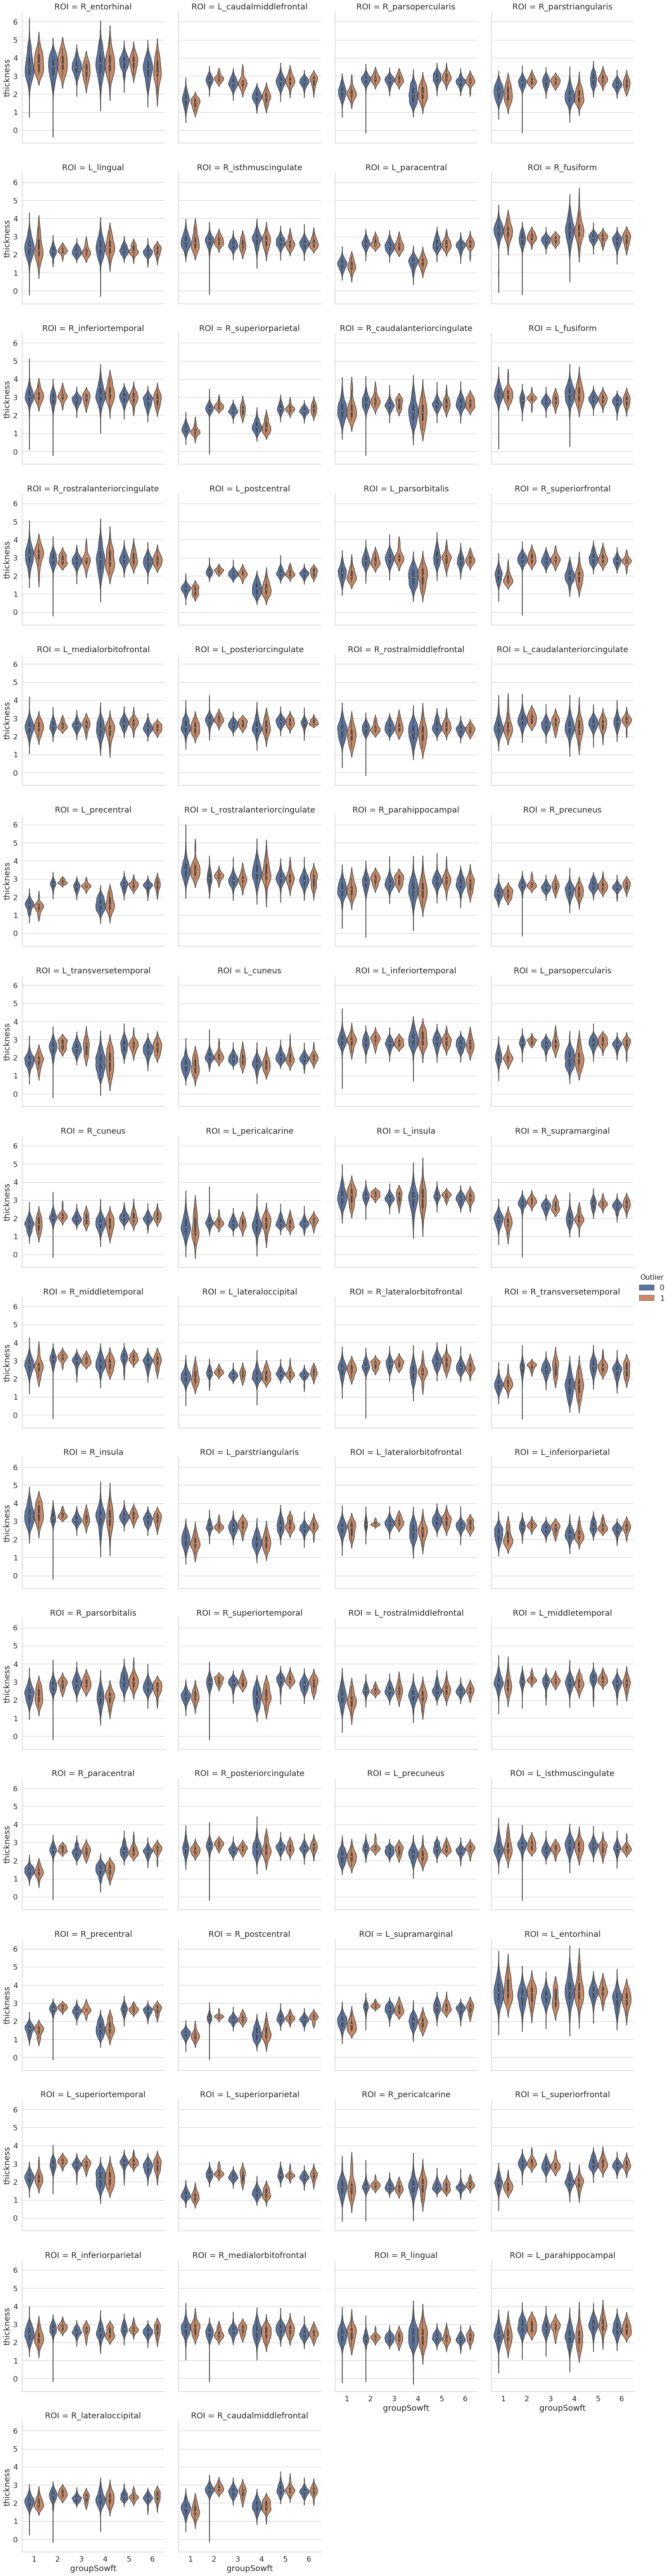

In [34]:
sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y='thickness', x='groupSowft', hue='Outlier', kind='violin', col='ROI', col_wrap=4, 
                    data=master_data_df_melt)


## Filter df based on outliers and concat (horizontally)

In [45]:
include_sub_tags = [0] # if 0 implies exclude outliers; else use [0,1]  

ants_data_std_filtered = ants_data_std[ants_data_std['Outlier'].isin(include_sub_tags)]
ants_data_corr = ants_data_std_filtered[common_cols]
ants_data_corr.columns = [str(col) + '_ants' for col in ants_data_corr.columns]
ants_data_corr = ants_data_corr.rename(columns={'SubjID_ants':'SubjID'})

fs51_data_std_filtered = fs51_data_std[fs51_data_std['Outlier'].isin(include_sub_tags)]
fs51_data_corr = fs51_data_std_filtered[common_cols]
fs51_data_corr.columns = [str(col) + '_fs51' for col in fs51_data_corr.columns]
fs51_data_corr = fs51_data_corr.rename(columns={'SubjID_fs51':'SubjID'})

fs53_data_std_filtered = fs53_data_std[fs53_data_std['Outlier'].isin(include_sub_tags)]
fs53_data_corr = fs53_data_std_filtered[common_cols]
fs53_data_corr.columns = [str(col) + '_fs53' for col in fs53_data_corr.columns]
fs53_data_corr = fs53_data_corr.rename(columns={'SubjID_fs53':'SubjID'})

concat_df = ants_data_corr.merge(fs51_data_corr, on='SubjID').merge(fs53_data_corr, on='SubjID')

## Plots: correlations

avg corr:
ants-fs51 0.4257248753376898, ants-fs53 0.4729011107650181, fs51-fs53 0.8718834636123061


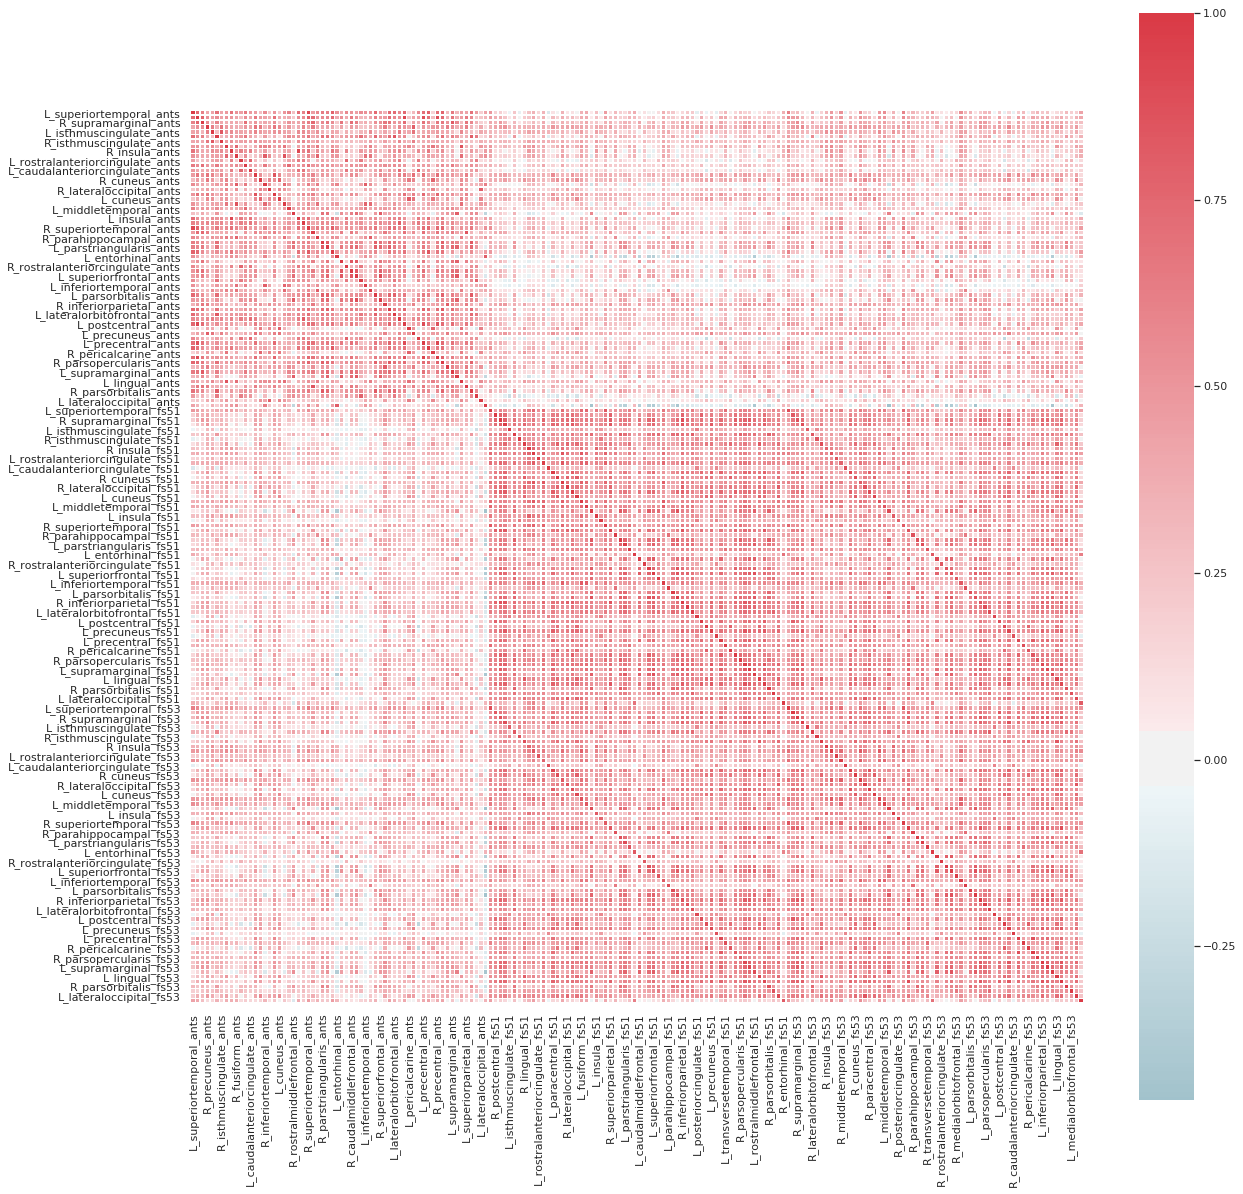

In [46]:
corr = concat_df.corr()

# avg cross-correlations using diangonals (corrwith from pandas doesn't work)
ants_fs51 = corr.values[:62,62:124].diagonal()
ants_fs53 = corr.values[:62,124:].diagonal()
fs51_fs53 = corr.values[62:124,124:].diagonal()

print('avg corr:\nants-fs51 {}, ants-fs53 {}, fs51-fs53 {}'.format(np.mean(ants_fs51),
                                                                   np.mean(ants_fs53),
                                                                   np.mean(fs51_fs53)))

# plot all pair-wise corrs (not really needed for seeing inter-pipeline comparisons)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#cmap = sns.diverging_palette(220, 20, n=7)

# Draw the heatmap with the mask and correct aspect ratio
plt.figure(figsize=(20,20))
sns.set(font_scale=1)
sns.heatmap(corr, cmap=cmap, square=True, linewidths=.5,center=0)


## Plots: clusters

Text(0.5, 0.98, 'fs5.3')

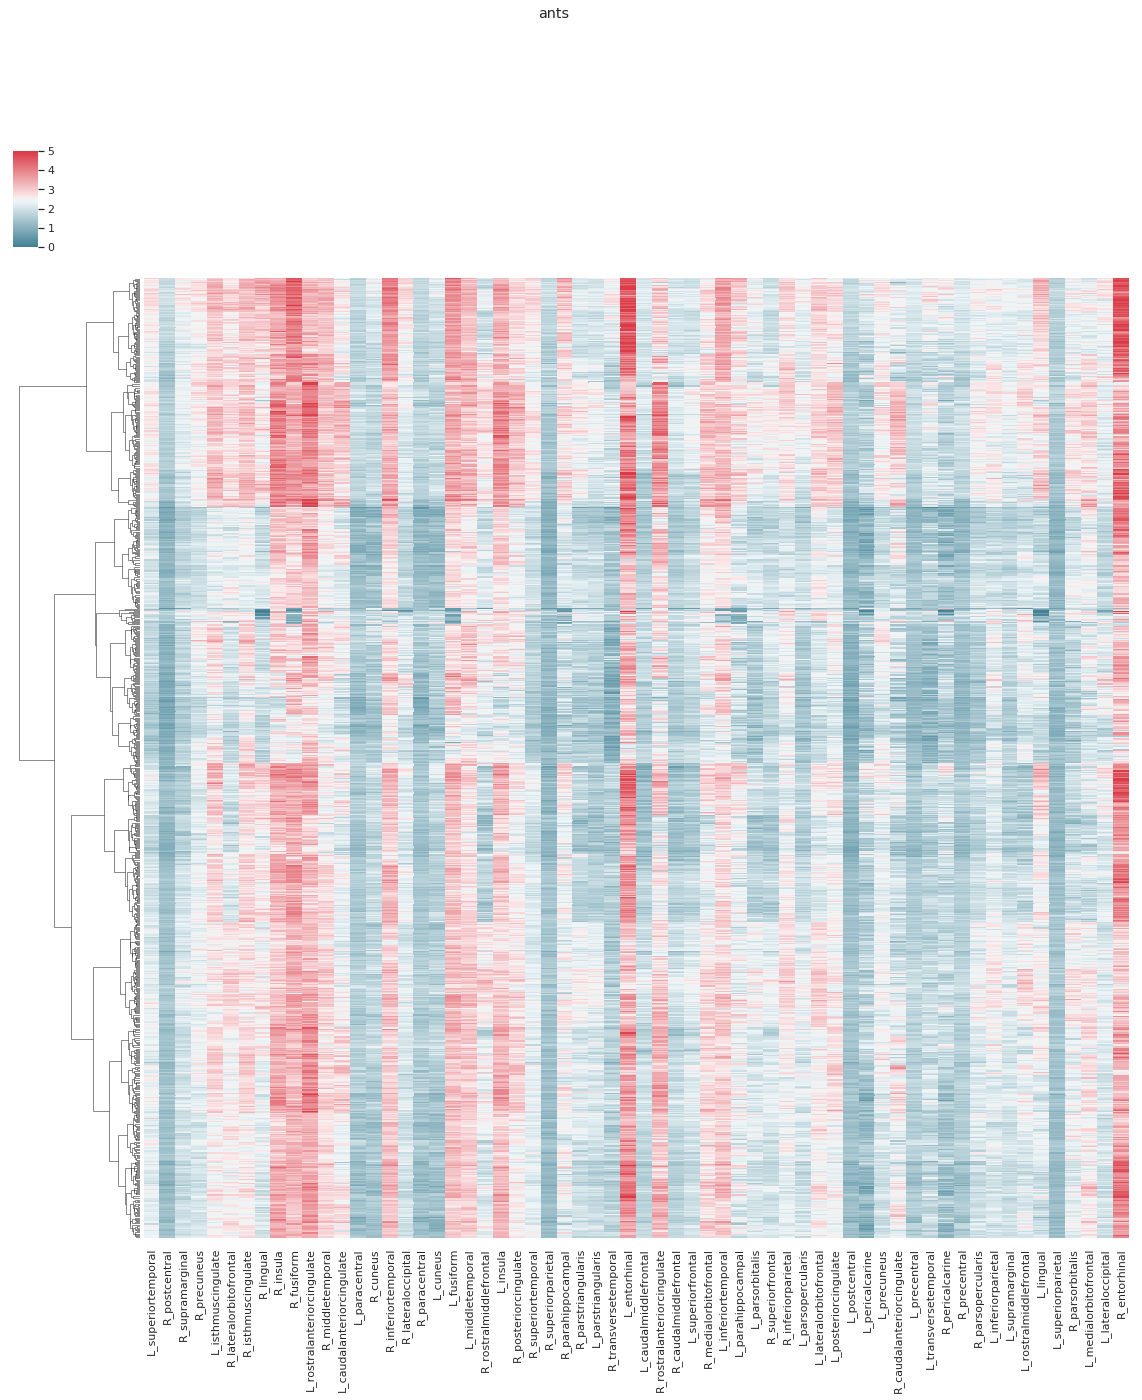

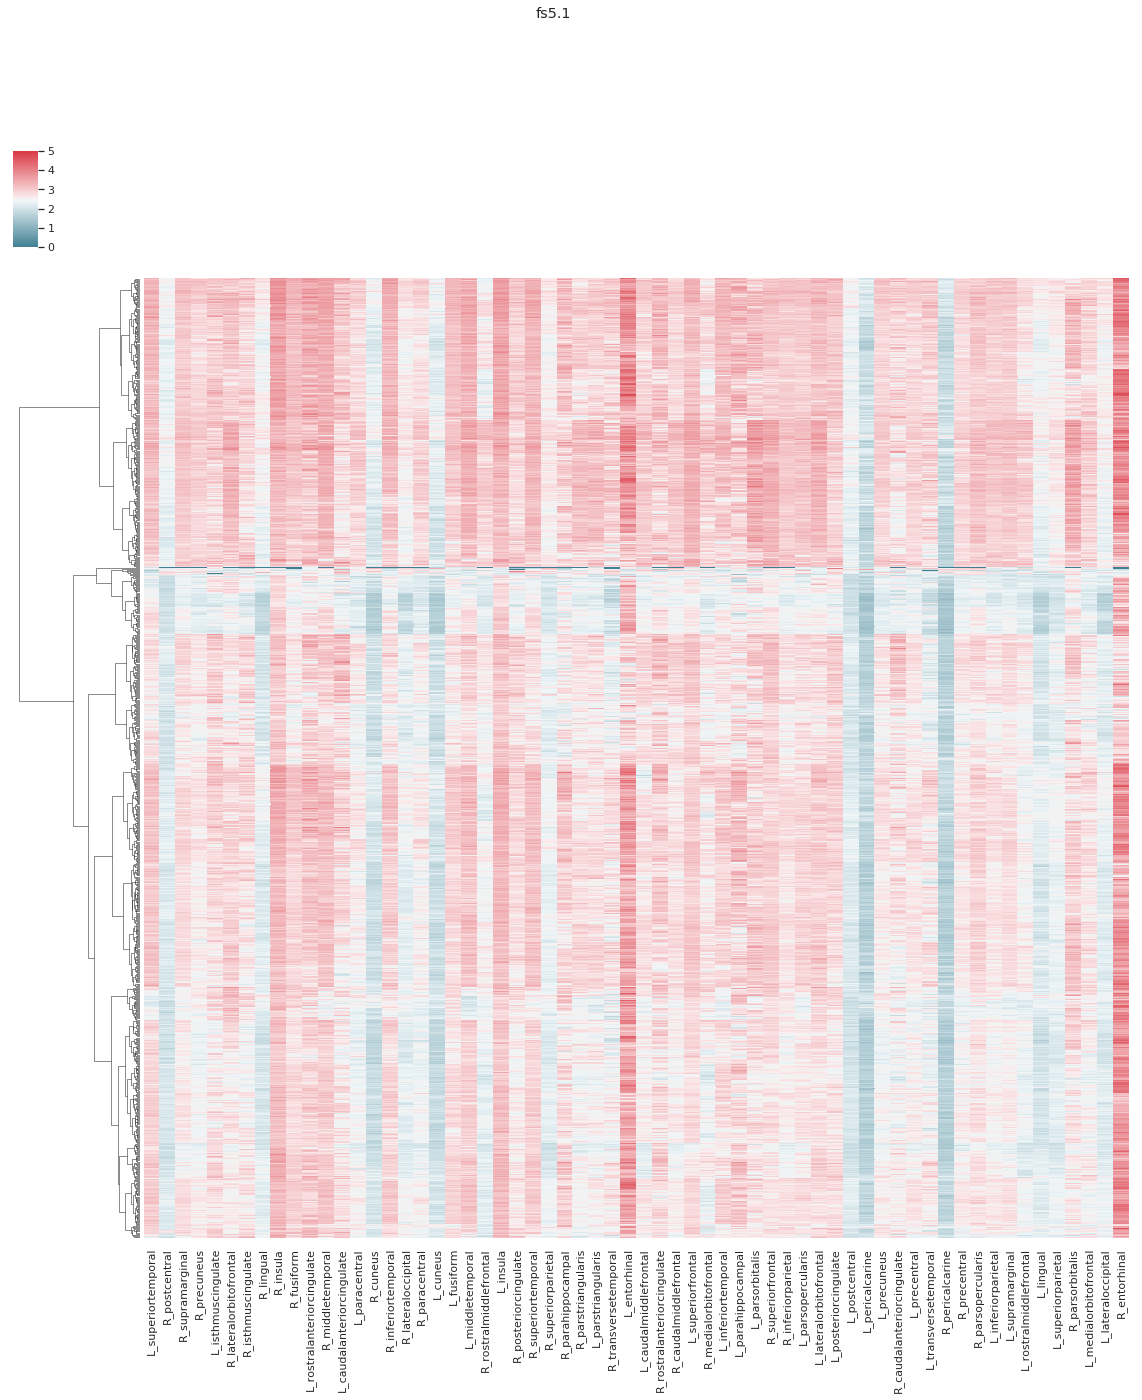

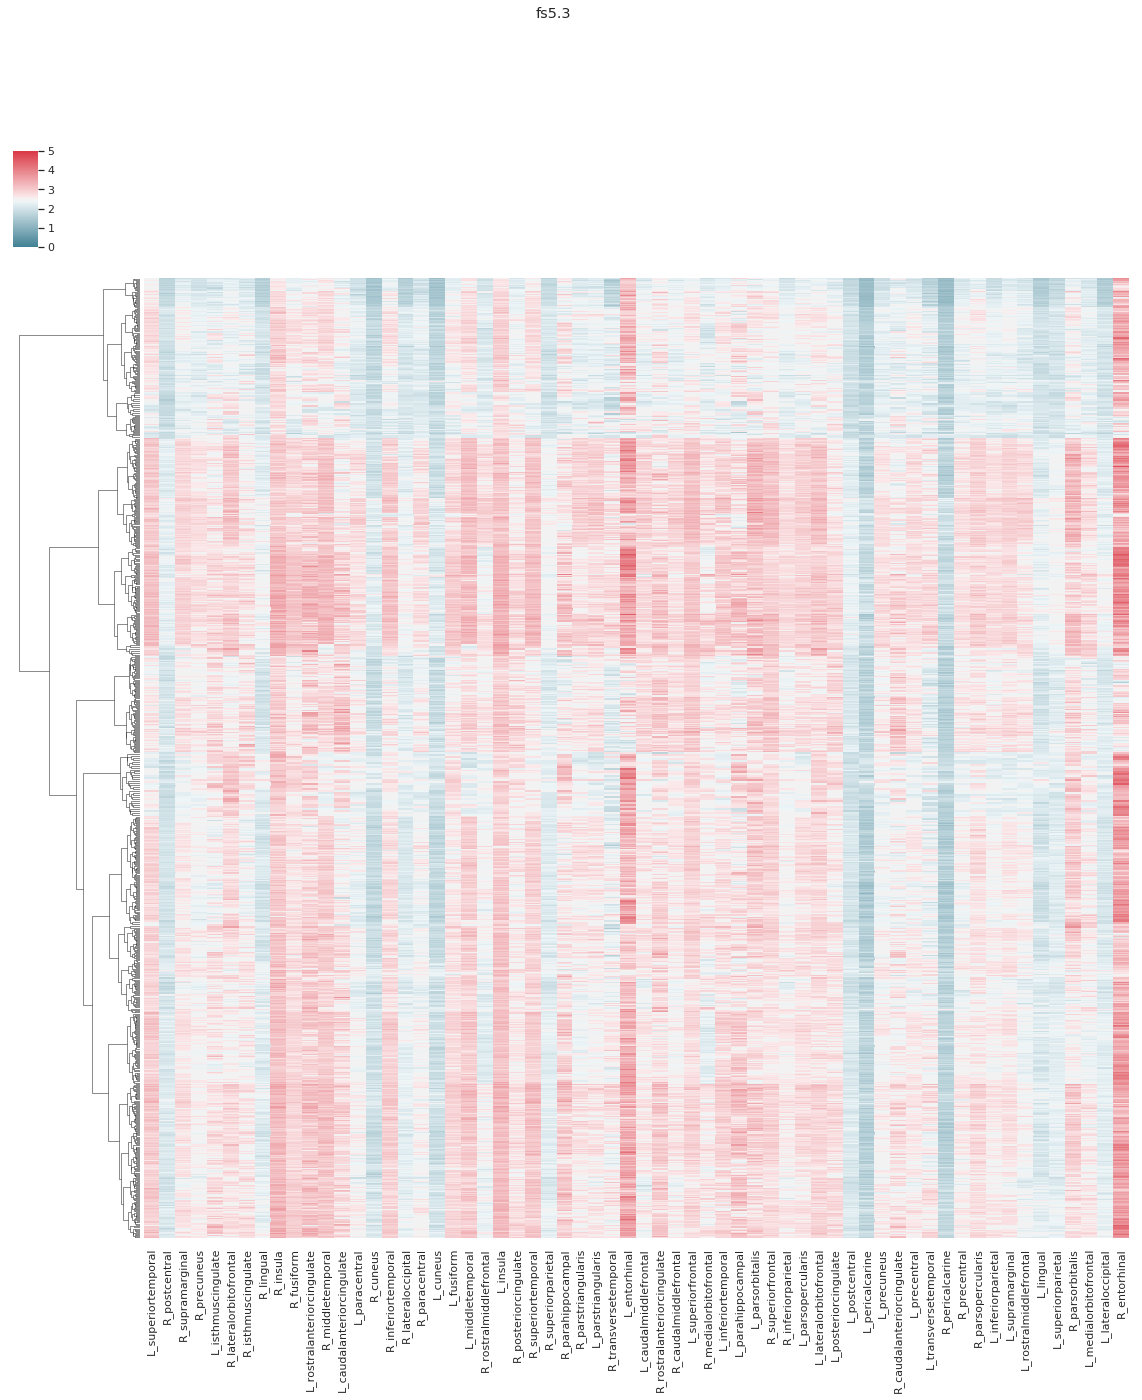

In [47]:
sns.set(style="white")
sns.set(font_scale=1)

similarity = 'euclidean'#'euclidean' #correlation
linkage = 'ward'

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

g1 = sns.clustermap(ants_data_std_filtered[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                   cmap=cmap, vmin=0, vmax=5, figsize=(20, 20),xticklabels=True, yticklabels=False)
g1.fig.suptitle('ants')

g2 = sns.clustermap(fs51_data_std_filtered[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                   cmap=cmap, vmin=0, vmax=5, figsize=(20, 20),xticklabels=True, yticklabels=False)
g2.fig.suptitle('fs5.1')

g3 = sns.clustermap(fs53_data_std_filtered[common_roi_cols], row_cluster=True, col_cluster=False, metric = similarity, method=linkage, 
                   cmap=cmap, vmin=0, vmax=5, figsize=(20, 20),xticklabels=True, yticklabels=False)
g3.fig.suptitle('fs5.3')

In [48]:
# cluster memberships
# Very basic - assumes same order of cluster-class for each pipeline 
# TODO - pairwise memberships

import scipy.cluster.hierarchy as sch
import collections

def get_cluster_membership(_df,g,n_clusters):
    member_df = _df[['SubjID','pipeline']].copy()
    Z = g.dendrogram_row.linkage
    T = sch.fcluster(Z, n_clusters, 'maxclust')
    member_count = collections.Counter(T)
    print('Pipeline {}, cluster sizes {}'.format(member_df['pipeline'].values[0], member_count))
    member_df['membership'] = T
    return member_df

def get_cluster_overlap(df1,df2):
    #assert len(df1) == len(df2)
    concat_df = pd.merge(df1,df2,on='SubjID',how='inner')
    overlap = np.sum(concat_df['membership_x'].values  == concat_df['membership_y'].values)/len(concat_df)
    return overlap                    

In [49]:
n_cluster = 2
print('Sanity check: largest and smallest clusters should have same cluster_ids across pipelines\n')
      
cluster_df = pd.DataFrame()
C1_member = get_cluster_membership(ants_data_std_filtered, g1, n_cluster)
C2_member = get_cluster_membership(fs51_data_std_filtered, g2, n_cluster)
C3_member = get_cluster_membership(fs53_data_std_filtered, g3, n_cluster)

C1_C2_overlap = get_cluster_overlap(C1_member,C2_member)
C1_C3_overlap = get_cluster_overlap(C1_member,C3_member)
C2_C3_overlap = get_cluster_overlap(C2_member,C3_member)

print('\ncluster membership overlap: C1_C2 {:3.2f}, C1_C3 {:3.2f}, C2_C3 {:3.2f}'.format(C1_C2_overlap,C1_C3_overlap,C2_C3_overlap))

Sanity check: largest and smallest clusters should have same cluster_ids across pipelines

Pipeline ants, cluster sizes Counter({2: 704, 1: 221})
Pipeline fs51, cluster sizes Counter({2: 652, 1: 281})
Pipeline fs53, cluster sizes Counter({2: 791, 1: 158})

cluster membership overlap: C1_C2 0.64, C1_C3 0.61, C2_C3 0.54


## Plot: t-SNE

In [35]:
from sklearn.manifold import TSNE
include_sub_tags = [0,1]

master_data_df_filtered = master_data_df[master_data_df['Outlier'].isin(include_sub_tags)]
X = master_data_df_filtered[common_roi_cols].values
X_embedded = TSNE(n_components=2,init='pca').fit_transform(X)
X_embedded.shape

(2925, 2)

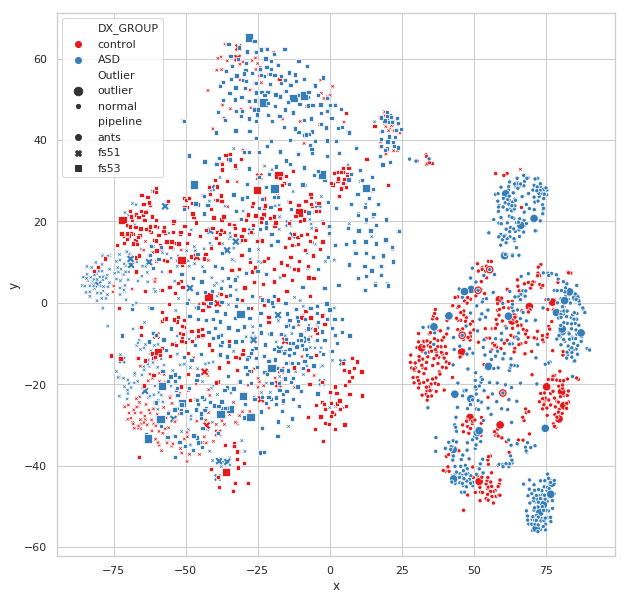

In [37]:
# plot
embed_df = pd.DataFrame(columns=['x','y'],data=X_embedded)
embed_df['groupSowft'] = master_data_df_filtered['groupSowft'].values
embed_df['pipeline'] = master_data_df_filtered['pipeline'].values
embed_df['DX_GROUP'] = master_data_df_filtered['DX_GROUP'].values
embed_df['Outlier'] = master_data_df_filtered['Outlier'].values

embed_df['groupSowft'] = embed_df['groupSowft'].replace({1:'ants+control', 2:'fs5.1+control', 3:'fs5.3+control',
                                                         4:'ants+ASD', 5:'fs5.1+ASD', 6:'fs5.3+ASD'})

embed_df['Outlier'] = embed_df['Outlier'].replace({1:'outlier', 0:'normal'})
embed_df['DX_GROUP'] = embed_df['DX_GROUP'].replace({1:'control', 2:'ASD'})

plt.figure(figsize=(10,10))
sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    sns.scatterplot(x='x',y='y',hue='DX_GROUP',size='Outlier',style='pipeline',data=embed_df,palette="Set1")

## ML classifier - sanity check

In [38]:
from sklearn.model_selection import cross_val_score
from sklearn import svm

pipe_pairs = {'ants vs. fs5.1' : ['ants','fs51'],
              'ants vs. fs5.3' : ['ants','fs53'],
              'fs5.1 vs. fs5.3' : ['fs51','fs53']}

n_folds = 10
scores = pd.DataFrame(columns=pipe_pairs.keys())
for i, pair in enumerate(pipe_pairs.keys()):
    ml_df = master_data_df_filtered[master_data_df_filtered['pipeline'].isin(pipe_pairs[pair])]
    X = ml_df[common_roi_cols].values
    y = pd.get_dummies(ml_df['pipeline']).values[:,0]

    clf = svm.SVC(kernel='linear', C=1)
    acc = cross_val_score(clf, X, y, cv=n_folds)
    scores[pair] = acc

    print('pipelines {}, discriminative acc mean:{:4.3f}, stdev:{:4.3f}'.format(pair,np.mean(acc),np.std(acc)))

pipelines ants vs. fs5.1, discriminative acc mean:0.998, stdev:0.003
pipelines ants vs. fs5.3, discriminative acc mean:0.999, stdev:0.002
pipelines fs5.1 vs. fs5.3, discriminative acc mean:0.723, stdev:0.073


# Sample Research Question
* Predict age from cortical thickness

In [46]:
import statsmodels.api as sm

useful_demograph = pheno[['SubjID','SEX','AGE_AT_SCAN','FIQ','BMI']]
study_data_df = pd.merge(master_data_df_filtered, useful_demograph, how='left', on='SubjID')
print(study_data_df.shape)

(2925, 71)


In [47]:
# Save master df
#study_data_df.to_csv(data_dir + 'study_data_df.csv')

## OLS: age ~ cortical_thickness [+ sex + Dx] 

In [48]:
# For proof-of-concept, currently implemented as multiple regression instead of mass-univariate

results_df = pd.DataFrame(columns=common_roi_cols + ['pipeline','metric'])
p = 0
for pipe in set(study_data_df['pipeline'].values):
    analysis_df = study_data_df[study_data_df['pipeline']==pipe]
    y = analysis_df['AGE_AT_SCAN'].values

    # OLS
    t_val_list = []
    R2_adj_list = []
    for roi in common_roi_cols:
        X = analysis_df[[roi,'SEX','DX_GROUP']].values #[DX,SEX]
        model = sm.OLS(y,X)
        results = model.fit()
        t_val = results.tvalues[0] # just for ROI
        r2_adj_val = results.rsquared_adj
        t_val_list.append(t_val)
        R2_adj_list.append(r2_adj_val)
        
    results_df.loc[p] = list(t_val_list) + [pipe,'t_val']
    p+=1
    results_df.loc[p] = list(R2_adj_list) + [pipe,'r2_adj']
    p+=1

In [49]:
results_df

,R_entorhinal,L_caudalmiddlefrontal,R_parsopercularis,R_parstriangularis,L_lingual,R_isthmuscingulate,L_paracentral,R_fusiform,R_inferiortemporal,R_superiorparietal,...,R_pericalcarine,L_superiorfrontal,R_inferiorparietal,R_medialorbitofrontal,R_lingual,L_parahippocampal,R_lateraloccipital,R_caudalmiddlefrontal,pipeline,metric
0,18.440334,8.468595,9.094459,7.518863,4.831662,7.431743,2.476824,11.493922,15.479117,5.141041,...,2.536166,8.834167,5.142839,14.298594,6.968896,10.862681,8.788730,8.346585,ants,t_val
1,0.838823,0.797386,0.799497,0.794395,0.787539,0.794134,0.783801,0.808468,0.825461,0.788196,...,0.783867,0.798606,0.788200,0.820246,0.792789,0.805989,0.798453,0.796987,ants,r2_adj
2,13.141367,10.180998,9.404522,7.192585,6.004936,8.187201,7.365370,10.192541,10.570124,8.859869,...,6.915489,8.573855,8.383164,6.040172,6.372501,10.656177,8.716922,9.302819,fs51,t_val
3,0.809967,0.797770,0.794869,0.787513,0.784209,0.790642,0.788034,0.797814,0.799276,0.792927,...,0.786699,0.791939,0.791294,0.784300,0.785179,0.799614,0.792430,0.794501,fs51,r2_adj
4,14.740568,10.981767,11.837686,10.360601,7.127764,8.584733,7.808074,11.792361,13.060232,10.195355,...,7.296274,9.592646,10.539985,9.347875,7.617686,12.099806,10.156546,10.916197,fs53,t_val
5,0.806755,0.789654,0.793348,0.787071,0.775301,0.780220,0.777511,0.793149,0.798854,0.786398,...,0.775833,0.784004,0.787808,0.783059,0.776877,0.794508,0.786242,0.789377,fs53,r2_adj


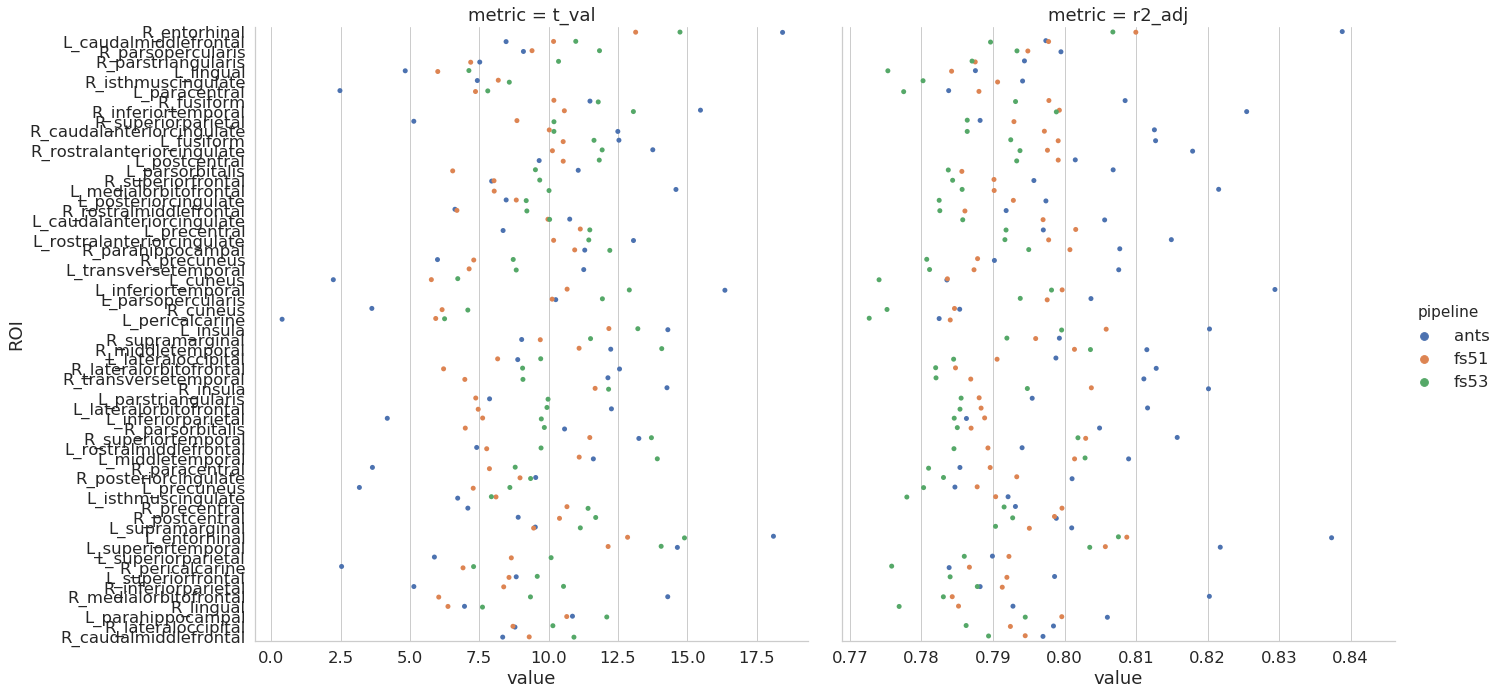

In [50]:
# Plot model results per pipeline

results_df_melt = pd.melt(results_df, id_vars=['pipeline','metric'], value_vars=common_roi_cols,
                             var_name='ROI', value_name='value')

sns.set(font_scale=1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x = 'value', y='ROI', hue='pipeline', col='metric', data=results_df_melt,
                    orient='h',kind='strip',aspect=1,height=10,sharex=False)
    #g.map(sns.stripplot, size=10)

In [ ]:
# Coe of variation across pipelines per ROI 
# List from John (Strict QC)
# CT differences based on age and Dx 
